In [1]:
import pyodbc
from meyerDB import cable_connection
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import HTML, display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeavePOut
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
import sklearn.preprocessing as pp
from sklearn.utils import shuffle
from scipy.optimize import curve_fit
from copy import deepcopy

from keras import models
from keras.layers import Dense, Dropout


# init db connection
conn = pyodbc.connect(cable_connection)
cursor = conn.cursor()
print('Database connection ok')

def display_table(data):
    html = "<table>"
    for row in data:
        html += "<tr>"
        for field in row:
            try:
                value = str(round(100*field, 1)).replace('.', ',') + '%'
            except:
                value = field
            html += "<td><h4>%s</h4><td>"%(value)
        html += "</tr>"
    html += "</table>"
    display(HTML(html))

def logifunc(x,x0,k,l):
    #l = 2300
    return l / (1 + np.exp(-k*(x - x0)))

Database connection ok


In [95]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, current total quantity, past 10 week time series
# Algorithms:
# Neural Network + linear regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " WHERE p.prototype=1"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

gtmax = gt.max()
ymax = y.max()
gt = gt/gtmax
y = y/ymax

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()

# train and evaluate
accuracies = []
r = 0
start = -80
window = 10
for train_i, test_i in lpo.split(y):
    r += 1
    if not (r % 1) == 0:
        continue
    X_train = []
    y_train = []

    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # train
    for i in train_i:
        ship = ships[i]
        step = 1
        for wk in range(start, 1, step):
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            features = [data[0][0]]#list(data[:, 0])
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            #features.append(linear_pred)
            features.append(wk/100.0)
            X_train.append(features)
            y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    # define model
    model = models.Sequential()
    model.add(Dense(64, activation='sigmoid', input_shape=(3,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(12, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train,
            batch_size=20,
            epochs=500,
            verbose=0)

    # evaluate
    step = 1
    x = []
    acc_func = []
    sums = []
    for wk in range(start, 1, step):
        X_test = []
        y_test = []
        for i in test_i:
            ship = ships[i]
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            features = [data[0][0]]#list(data[:, 0])
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            #features.append(linear_pred)
            features.append(wk/100.0)
            X_test.append(features)
            y_test.append(y[i])
        sums.append(current_sum)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        #get current progress
        cursor.execute(
            "SELECT"
            " sum(CASE WHEN wk <= {} THEN cables ELSE 0.0 END),"
            " sum(cast(cables as float))"
            " FROM progress WHERE project_id={}"
            .format(wk, ship)
        )
        progress = wk#cursor.fetchall()[0][0]

        preds = model.predict(X_test)
        #preds = linearModel.predict(X_test)
        y_true = y_test
        acc = 100*(1-mape(y_true, preds))
        x.append(progress)
        acc_func.append(acc)
    accuracies.append(acc_func)


accuracies = np.array(accuracies)
mean_acc_func = accuracies.mean(axis=0)
plt.plot(x, mean_acc_func)
plt.ylim([50, 100])
plt.show()

            

KeyboardInterrupt: 

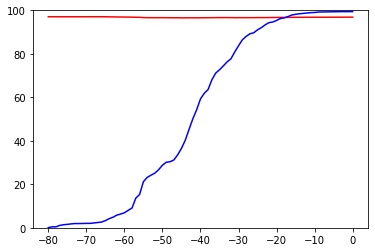

In [28]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, current total quantity, past 10 week time series
# Algorithms:
# Neural Network + linear regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " GROUP BY r.project_id, gross_tonnage")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
y = data[:, -1]

gtmax = gt.max()
ymax = y.max()
gt = gt/gtmax
y = y/ymax

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()

# train and evaluate
accuracies = []
accuracies2 = []
r = 0
start = -80
window = 20
for train_i, test_i in lpo.split(y):
    r += 1
    if not (r % 20) == 0:
        continue
    X_train = []
    y_train = []

    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    # train
    for i in train_i:
        ship = ships[i]
        step = 1
        for wk in range(start, 1, step):
            cursor.execute(
                "SELECT cables FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            #features = list(data[:, 0])
            x2 = range(0, window)
            [k, b] = np.polyfit(x2, data[:, 0], 1)
            features = [k]
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            features.append(linear_pred)
            features.append(wk/100.0)
            X_train.append(features)
            y_train.append(y[i])
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_train, y_train = shuffle(X_train, y_train, random_state=0)
    # define model
    model = models.Sequential()
    model.add(Dense(64, activation='sigmoid', input_shape=(4,)))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(12, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    model.compile(optimizer='adam',
                loss='mean_squared_error',
                metrics=['accuracy'])

    # Train model
    model.fit(X_train, y_train,
            batch_size=20,
            epochs=3000,
            verbose=0)

    # evaluate
    step = 1
    x = []
    acc_func = []
    acc_func2 = []
    sums = []
    
    for wk in range(start, 1, step):
        X_test = []
        y_test = []
        preds2 = []
        for i in test_i:
            ship = ships[i]
            cursor.execute(
                "SELECT cables FROM progress WHERE"
                " wk > {} AND wk <= {} AND project_id={}"
                .format(wk - window, wk, ship)
            )
            data = np.array(cursor.fetchall())/ymax
            #features = list(data[:, 0])
            x2 = range(0, window)
            [k, b] = np.polyfit(x2, data[:, 0], 1)
            features = [k]
            cursor.execute(
                "SELECT sum(cables) FROM progress WHERE"
                " wk <= {} AND project_id={}"
                .format(wk, ship)
            )
            current_sum = cursor.fetchall()[0][0]/ymax
            features.append(current_sum)
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            features.append(linear_pred)
            features.append(wk/100.0)
            X_test.append(features)
            y_test.append(y[i])
            preds2.append(current_sum)
        sums.append(current_sum)
        X_test = np.array(X_test)
        y_test = np.array(y_test)
        #get current progress
        cursor.execute(
            "SELECT"
            " sum(CASE WHEN wk <= {} THEN cables ELSE 0.0 END),"
            " sum(cast(cables as float))"
            " FROM progress WHERE project_id={}"
            .format(wk, ship)
        )
        progress = wk#cursor.fetchall()[0][0]

        preds = model.predict(X_test)
        y_true = y_test
        acc = 100*(1-mape(y_true, preds))
        x.append(progress)
        acc_func.append(acc)
        acc2 = 100*(1-mape(y_true, preds2))
        acc_func2.append(acc2)
    accuracies.append(acc_func)
    accuracies2.append(acc_func2)

accuracies = np.array(accuracies)
mean_acc_func = accuracies.mean(axis=0)
accuracies2 = np.array(accuracies2)
mean_acc_func2 = accuracies2.mean(axis=0)
plt.plot(x, mean_acc_func, 'r')
plt.plot(x, mean_acc_func2, 'b')
plt.ylim([0, 100])
plt.show()

            

C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi53\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\optimize\minpack.py:828: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
C:\Users\sainmi5

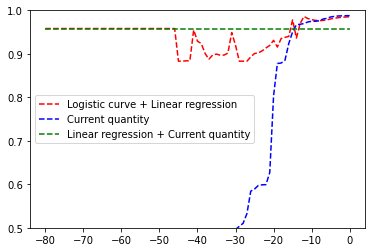

In [6]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, current total quantity, past 10 week time series
# Algorithms:
# Logistic curve regression + Linear Regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()

# train and evaluate

for start in [-16, -80]:
    r = 0
    for train_i, test_i in lpo.split(y):
        if pt[test_i].sum() < 2:
            pass
        accuracies = []
        accuracies2 = []
        accuracies3 = []
        r += 1
        if not (r % 1) == 0:
            continue
        linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])

        # evaluate
        step = 1
        x = []
        acc_func = []
        acc_func2 = []
        acc_func3 = []
        sums = []
        for wk in range(start, 1, step):
            y_test = []
            preds = []
            preds2 = []
            preds3 = []
            for i in test_i:
                ship = ships[i]
                linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
                cursor.execute(
                    "SELECT wk, cables FROM progress WHERE"
                    " wk <= {} AND project_id={} ORDER BY wk"
                    .format(wk, ship)
                )
                data = np.array(cursor.fetchall())
                sequence = data[:, -1].cumsum()
                xseq = data[:, 0]
                lim = (linear_pred*0.5)
                if sequence[-1] >= lim:
                    cut = np.argmax(sequence > lim)
                    sequence = sequence[cut:]
                    xseq = xseq[cut:]
                    
                    scaler = 0.15
                    low = linear_pred - (linear_pred*scaler)
                    if sequence[-1] > low:
                        low = sequence[-1]
                    high = linear_pred + (linear_pred*scaler)
                    if low > high:
                        high = low + (low*scaler)
                    (x0hat, khat, lhat), _ = curve_fit(logifunc, xseq, sequence, bounds=([-100, 0, low], [0, 0.5, high]))
                    preds.append(lhat)
                else:
                    preds.append(linear_pred)
                preds2.append(sequence[-1])
                if sequence[-1]>linear_pred:# abs(sequence[-1]-linear_pred)/linear_pred < 0.2:
                    preds3.append(sequence[-1])
                else:
                    preds3.append(linear_pred)
                y_test.append(y[i])
                if False:
                    plt.plot(xseq, sequence)
                    plt.plot(xseq, logifunc(xseq, x0hat, khat, lhat))
                    plt.show()
                    input('pause')


            y_true = y_test
            acc = (1-mape(y_true, preds))
            acc_func.append(acc)
            acc = (1-mape(y_true, preds2))
            acc_func2.append(acc)
            acc = (1-mape(y_true, preds3))
            acc_func3.append(acc)
            x.append(wk)
        accuracies.append(acc_func)
        accuracies2.append(acc_func2)
        accuracies3.append(acc_func3)


    accuracies = np.array(accuracies)
    mean_acc_func = accuracies.mean(axis=0)
    accuracies2 = np.array(accuracies2)
    mean_acc_func2 = accuracies2.mean(axis=0) 
    accuracies3 = np.array(accuracies3)
    mean_acc_func3 = accuracies3.mean(axis=0)
    table_rows = [['Model', 'mean (from {} weeks to delivery)'.format(abs(start))]]
    table_rows.append(['Logistic curve + Linear regression', mean_acc_func.mean()])
    table_rows.append(['Current quantity', mean_acc_func2.mean()])
    table_rows.append(['Linear regression + Current quantity', mean_acc_func3.mean()])
    display_table(table_rows)


plt.plot(x, mean_acc_func, 'r--')
plt.plot(x, mean_acc_func2, 'b--')
plt.plot(x, mean_acc_func3, 'g--')
plt.ylim([0.5, 1])
plt.legend(['Logistic curve + Linear regression', 'Current quantity', 'Linear regression + Current quantity'])
plt.show()

            

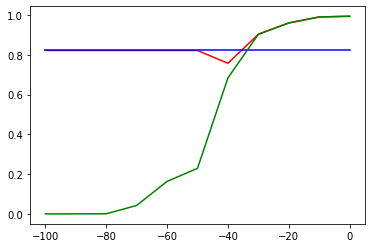

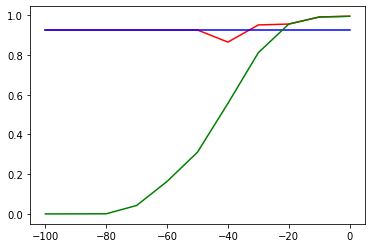

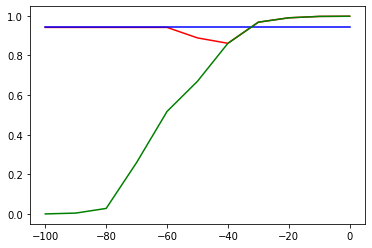

KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [5]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, past weeks time series
# Algorithms:
# Dummy
# Linear regression

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    #" WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()



for train_i, test_i in lpo.split(y):

    # train regression model
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])

    # collect time series train data
    start = -100
    step = 10
    y_fit = []
    X_fit = []
    X_scalers = []
    y_train = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, [-1]]
            xseq = data[:, [0]]
            if sequence.sum() >= (0.5*linear_pred):
                X_fit.append(xseq)
                X_scalers.append(linear_pred)
                y_fit.append(sequence/linear_pred)
                y_train.append(y[i])
    # evaluate model
    gaussian_accs = []
    linear_accs = []
    dummy_accs = []
    x = []
    for wk in range(start, 1, step):
        gaussian_preds = []
        y_reals = []
        linear_preds = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, [-1]]
            xseq = data[:, [0]]
            if sequence.sum() >= (0.8*linear_pred):
                gaussian_preds.append(sequence.sum())
            else:
                gaussian_preds.append(linear_pred)
            linear_preds.append(linear_pred)
            dummy_preds.append(sequence.sum())
            y_reals.append(y[i])
        if len(y_reals)<1: continue
        gaussian_mape = mape(y_reals, gaussian_preds)
        linear_mape = mape(y_reals, linear_preds)
        dummy_mape = mape(y_reals, dummy_preds)

        gaussian_accs.append(1-gaussian_mape)
        linear_accs.append(1-linear_mape)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)
    
    plt.plot(x, gaussian_accs, 'r')
    plt.plot(x, linear_accs, 'b')
    plt.plot(x, dummy_accs, 'g')
    plt.show()
    plt.figure()

In [3]:
# distribution matching functions

def match_distribution(target_dist, current_dist, current_vals):
    corr_coefs = target_dist/current_dist
    scaled_vals = np.multiply(corr_coefs, current_vals)
    highest_gap = np.argmax(current_dist-scaled_vals)
    match_scaler = current_vals[highest_gap]/scaled_vals[highest_gap]
    return scaled_vals*match_scaler
def match_distribution2(target_dist, current_dist, current_vals, target_sum):
    target_vals = target_dist*target_sum
    for i in range(target_vals.shape[0]):
        if (abs(current_vals[i]-target_vals[i])/target_sum) > 0.25:
            current_vals[i] = target_vals[i]
    return current_vals

def get_distribution(ships, pwk=0, rwk=0):
    rel_sections = []
    sections = []
    for i, ship in enumerate(ships):
        sections.append([])
        rel_sections.append([])
        cursor.execute(
            " SELECT location_set.project_id, sum(amount)/totals.total as rel_quantity, "
            "sum(amount) as quantity, x, y FROM location_set"
            " LEFT JOIN (SELECT project_id, 2.0*sum(amount) as total FROM routed"
            " WHERE frame1 IS NOT NULL AND frame2 IS NOT NULL AND deck1 IS NOT NULL AND deck2 IS NOT NULL"
            " AND pwk<{} AND rwk<{}"
            " GROUP BY project_id) totals"
            " ON totals.project_id=location_set.project_id"
            " WHERE location_set.project_id={} AND pwk<{} AND rwk<{}"
            " GROUP BY location_set.project_id, x, y, totals.total"
            " ORDER BY y DESC, x"
                    .format(pwk, rwk, ship, pwk, rwk)
            )
        data = np.array(cursor.fetchall())

        if data.shape[0] != 9:
            #print("fail", data.shape[0], wk)
            return np.array([]), np.array([]), 0

        relative_quantity = data[:, 1].astype('float32')
        quantity = data[:, 2].astype('float32')
        for ii in range(relative_quantity.shape[0]):
            rel_sections[i].append(relative_quantity[ii])
            sections[i].append(quantity[ii])

    sections = np.array(sections)
    rel_sections = np.array(rel_sections)
    rel_targets, targets, errors = [], [], []
    for i in range(9):
        rel_targets.append(rel_sections[:, i].mean())
        targets.append(sections[:, i].mean())
        errors.append(rel_sections[:, i].std())

    return np.array(rel_targets), np.array(targets), np.array(errors).mean()

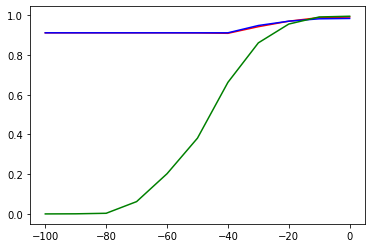

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [7]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, past weeks time series
# Algorithms:
# Cable distribution matching + Linear regression


# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    #" WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()
all_linear_acc = []
all_gaussian_acc = []
all_dummy_acc = []
r = 1
for train_i, test_i in lpo.split(y):
    if r ==12: break
    r+=1
    # train regression model
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])

    # collect time series train data
    start = -100
    step = 10
    y_fit = []
    X_fit = []
    X_scalers = []
    y_train = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, [-1]]
            xseq = data[:, [0]]
            #if sequence.sum() >= (0.5*linear_pred):
            X_fit.append(xseq)
            X_scalers.append(linear_pred)
            y_fit.append(sequence/linear_pred)
            y_train.append(y[i])
    # get targets for cable distribution
    #target_dist, target_vals, ref_error = get_distribution(ships[train_i])
    #print(ref_error)
    # evaluate model
    gaussian_accs = []
    linear_accs = []
    dummy_accs = []
    x = []
    for wk in range(start, 1, step):
        gaussian_preds = []
        y_reals = []
        linear_preds = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, [-1]]
            xseq = data[:, [0]]
            #current_dist, current_vals, error = get_distribution([ship], pwk=wk)
            dummy_preds.append(sequence.sum())
            if sequence.sum()>linear_pred:
                linear_preds.append(sequence.sum())
            else:
                linear_preds.append(linear_pred)
            if sequence.sum()>0.9*linear_pred:
                gaussian_preds.append(sequence.sum())
            else:
                gaussian_preds.append(linear_pred)
            y_reals.append(y[i])
        if len(y_reals)<1: continue
        gaussian_mape = mape(y_reals, gaussian_preds)
        linear_mape = mape(y_reals, linear_preds)
        dummy_mape = mape(y_reals, dummy_preds)

        gaussian_accs.append(1-gaussian_mape)
        linear_accs.append(1-linear_mape)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)

    all_dummy_acc.append(dummy_accs)
    all_gaussian_acc.append(gaussian_accs)
    all_linear_acc.append(linear_accs)


all_dummy_acc = np.array(all_dummy_acc)
all_gaussian_acc = np.array(all_gaussian_acc)
all_linear_acc = np.array(all_linear_acc)

plt.plot(x, all_gaussian_acc.mean(axis=0), 'r')
plt.plot(x, all_linear_acc.mean(axis=0), 'b')
plt.plot(x, all_dummy_acc.mean(axis=0), 'g')
plt.show()
plt.figure()
    

0.9419561197432019 0.945095115941302


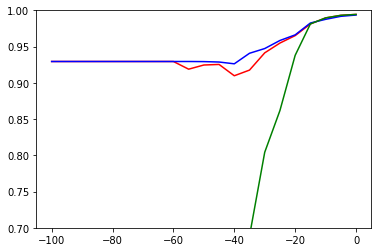

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [46]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, past weeks time series
# Algorithms:
# linear regression + logistic curve fitting

def logifunc(x,x0,k,l):
    return l / (1 + np.exp(-k*(x - x0)))

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    #" WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()
all_linear_acc = []
all_gaussian_acc = []
all_dummy_acc = []
r = 1
for train_i, test_i in lpo.split(y):
    #if r ==12: break
    r+=1
    # train regression model
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])

    # collect time series train data
    start = -100
    step = 100
    y_fit = []
    X_fit = []
    X_scalers = []
    y_train = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, [-1]]
            xseq = data[:, [0]]
            #if sequence.sum() >= (0.5*linear_pred):
            X_fit.append(xseq)
            X_scalers.append(linear_pred)
            y_fit.append(sequence/linear_pred)
            y_train.append(y[i])

    # evaluate model
    gaussian_accs = []
    linear_accs = []
    dummy_accs = []
    x = []
    step = 5
    for wk in range(start, 1, step):
        gaussian_preds = []
        y_reals = []
        linear_preds = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            xseq = data[:, 0]
            dummy_preds.append(sequence.sum())
            if sequence.sum()>0.9*linear_pred:
                linear_preds.append(sequence.sum())
            else:
                linear_preds.append(linear_pred)
            if sequence.sum()>0.8*linear_pred:
                trace = 7
                (x0hat, khat, lhat), _ = curve_fit(logifunc, xseq[-trace:], sequence[-trace], bounds=([-70, 0.1, sequence.sum()], [-20, 1, sequence.sum()*1.5]))
                gaussian_preds.append(lhat)
            else:
                gaussian_preds.append(linear_pred)
            y_reals.append(y[i])
        if len(y_reals)<1: continue
        gaussian_mape = mape(y_reals, gaussian_preds)
        linear_mape = mape(y_reals, linear_preds)
        dummy_mape = mape(y_reals, dummy_preds)

        gaussian_accs.append(1-gaussian_mape)
        linear_accs.append(1-linear_mape)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)

    all_dummy_acc.append(dummy_accs)
    all_gaussian_acc.append(gaussian_accs)
    all_linear_acc.append(linear_accs)


all_dummy_acc = np.array(all_dummy_acc)
all_gaussian_acc = np.array(all_gaussian_acc)
all_linear_acc = np.array(all_linear_acc)
print(all_gaussian_acc.mean(), all_linear_acc.mean())
plt.plot(x, all_gaussian_acc.mean(axis=0), 'r')
plt.plot(x, all_linear_acc.mean(axis=0), 'b')
plt.plot(x, all_dummy_acc.mean(axis=0), 'g')
plt.ylim(0.7, 1.0)
plt.show()
plt.figure()

0.955697043020938 0.9501086745976848


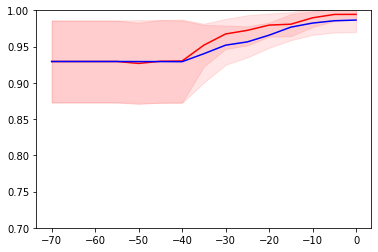

In [94]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, past weeks time series
# Algorithms:
# linear regression

def logifunc(x,x0,k,l):
    return l / (1 + np.exp(-k*(x - x0)))

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    #" WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()
all_linear_acc = []
all_gaussian_acc = []
all_dummy_acc = []
r = 1
for train_i, test_i in lpo.split(y):
    #if r == 4: break
    r+=1
    # train regression model
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    preds = linearModel.predict(gt[train_i].reshape(-1, 1))
    est_error =  (abs(y[train_i] - preds)/y[train_i]).max()
    est_acc = 1-est_error
    # collect time series train data
    start = -70
    step = 5
    y_fit = []
    X_fit = []
    X_scalers = []
    X_train = []
    y_train = []
    trace = 16
    sequences = []
    scalers = []
    ys = []
    cumsums = []
    wks = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            sequences.append(sequence)
            scalers.append(linear_pred)
            ys.append(y[i])
            

    best_err = np.inf
    best_dum_err = np.inf
    for lim1 in np.linspace(0.7, 0.99, 17):
        for lim2 in np.linspace(0.08, 0.2, 5):
                for trace in np.arange(4, 12):
                    y_fit = []
                    X_fit = []
                    for i, sequence in enumerate(sequences):
                        linear_pred = scalers[i]
                        yy = ys[i]
                        if sequence.sum()>lim1*linear_pred:
                            s = sequence[-trace:].sum()/linear_pred
                            if s < lim2:
                                X_fit.append(s)
                                y_fit.append((yy - sequence.sum())/linear_pred)
                    if len(X_fit) == 0: break
                    if sum(X_fit) < 0.001: break 
                    [k, b] = np.polyfit(X_fit, y_fit, 1)
                    errs = []
                    dum_errs = []
                    for i, sequence in enumerate(sequences):
                        linear_pred = scalers[i]
                        if sequence.sum() > lim1*linear_pred:
                            pred = sequence.sum()
                        else:
                            pred = linear_pred
                        dum_errs.append(np.square(ys[i]-pred))
                        if sequence.sum() > lim1*linear_pred:
                            add = (sequence[-trace:].sum()/linear_pred)*k + b
                            pred = sequence.sum() + add*linear_pred
                            if pred > (2-lim1)*sequence.sum(): pred = (2-lim1)*sequence.sum()
                        else:
                            pred = linear_pred
                        errs.append(np.square(ys[i]-pred))
                    if np.array(errs).mean() < best_err:
                        best_err = np.array(errs).mean()
                        params = (lim1, lim2, trace)
                        coefs = [k, b]
                    if np.array(dum_errs).mean() < best_dum_err:
                        best_dum_err = np.array(dum_errs).mean()
                        dum_lim = lim1
    #print(params, dum_lim)
    [k, b] = coefs
    (lim1, lim2, trace) = params
    #plt.plot(X_fit, np.poly1d(fit(X_fit))
    #plt.show()
    

    # evaluate model
    gaussian_accs = []
    linear_accs = []
    dummy_accs = []
    x = []
    step = 5
    for wk in range(start, 1, step):
        gaussian_preds = []
        y_reals = []
        linear_preds = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            xseq = data[:, 0]
            dummy_preds.append(sequence.sum())
            if sequence.sum()>dum_lim*linear_pred:
                linear_preds.append(sequence.sum())
            else:
                linear_preds.append(linear_pred)
            if sequence.sum()>lim1*linear_pred:
                add = (sequence[-trace:].sum()/linear_pred)*k + b
                pred = sequence.sum() + add*linear_pred
                if pred > (2-lim1)*sequence.sum(): pred = (2-lim1)*sequence.sum()
                gaussian_preds.append(pred)
            else:
                gaussian_preds.append(linear_pred)
            y_reals.append(y[i])
        if len(y_reals)<1: continue
        gaussian_mape = mape(y_reals, gaussian_preds)
        linear_mape = mape(y_reals, linear_preds)
        dummy_mape = mape(y_reals, dummy_preds)

        gaussian_accs.append(1-gaussian_mape)
        linear_accs.append(1-linear_mape)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)

    all_dummy_acc.append(dummy_accs)
    all_gaussian_acc.append(gaussian_accs)
    all_linear_acc.append(linear_accs)


all_dummy_acc = np.array(all_dummy_acc)
all_gaussian_acc = np.array(all_gaussian_acc)
all_linear_acc = np.array(all_linear_acc)
print(all_gaussian_acc.mean(), all_linear_acc.mean())
lws = plt.gcf().get_figheight() * plt.gcf().dpi / 0.3
plt.plot(x, all_gaussian_acc.mean(axis=0), 'r')
#plt.plot(x, all_gaussian_acc.min(axis=0), 'r--')
plt.fill_between(x, all_gaussian_acc.mean(axis=0) - all_gaussian_acc.std(axis=0),
                all_gaussian_acc.mean(axis=0) + all_gaussian_acc.std(axis=0),
                alpha=0.1, color='r')
plt.ylim(0.7, 1.0)
#plt.figure()
plt.plot(x, all_linear_acc.mean(axis=0), 'b')
#plt.plot(x, all_linear_acc.min(axis=0), 'b--')
plt.fill_between(x, all_linear_acc.mean(axis=0) - all_linear_acc.std(axis=0),
                all_linear_acc.mean(axis=0) + all_linear_acc.std(axis=0),
                alpha=0.1, color='r')
plt.ylim(0.7, 1.0)
#plt.plot(x, all_dummy_acc.mean(axis=0), 'g')
#plt.plot(x, all_dummy_acc.min(axis=0), 'g--')



plt.show()

# 0.9472411538301978 0.945095115941302 0.8, 0.15, 9

(11, 5)
0.9516996922618896 0.9501086601078594


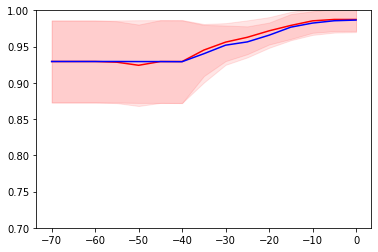

In [4]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, past weeks time series
# Algorithms:
# linear regression

def logifunc(x,x0,k,l):
    return l / (1 + np.exp(-k*(x - x0)))

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, ship_squares, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    " LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON r.project_id=a.project_id"
    #" WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype, ship_squares")
data = np.array(cursor.fetchall()).astype('float32')
print(data.shape)
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
sq = data[:, 3]
gts = data[:, [1, 3]]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()
train_model = linear_model.LinearRegression()
all_linear_acc = []
all_gaussian_acc = []
all_dummy_acc = []
r = 0
for train_i, test_i in lpo.split(y):
    r+=1
    if not  r % 1 == 0: continue
    # train regression model
    linearModel.fit(gt[train_i].reshape(-1, 1), y[train_i])
    #preds = linearModel.predict(gts[train_i].reshape(-1, 1))
    # collect time series train data
    start = -70
    step = 5
    y_fit = []
    X_fit = []
    X_scalers = []
    X_train = []
    y_train = []
    trace = 16
    sequences = []
    scalers = []
    scalers2 = []
    ys = []
    cumsums = []
    wks = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            sequences.append(sequence)
            scalers.append(linear_pred)
            scalers2.append( gt[i])
            ys.append(y[i])
            

    best_err = np.inf
    best_dum_err = np.inf
    for lim1 in np.linspace(0.7, 0.99, 17):
        for lim2 in np.linspace(0.08, 0.25, 6):
                for trace in np.arange(4, 12):
                    y_fit = []
                    X_fit = []
                    for i, sequence in enumerate(sequences):
                        linear_pred = scalers[i]
                        yy = ys[i]
                        if sequence.sum()>lim1*linear_pred:
                            s = sequence[-trace:].sum()
                            if s < lim2*linear_pred:
                                X_fit.append( (s, scalers2[i]) )
                                y_fit.append(yy - sequence.sum())
                    if len(X_fit) == 0: break
                    #if sum(X_fit) < 0.001: break 
                    #[k, b] = np.polyfit(X_fit, y_fit, 1)
                    train_model.fit(np.array(X_fit), y_fit)
                    errs = []
                    dum_errs = []
                    for i, sequence in enumerate(sequences):
                        linear_pred = scalers[i]
                        s = sequence[-trace:].sum()
                        if sequence.sum() > lim1*linear_pred:
                            pred = sequence.sum()
                        else:
                            pred = linear_pred
                        dum_errs.append(np.square(ys[i]-pred))
                        if sequence.sum() > lim1*linear_pred:
                            add = train_model.predict( np.array([s, scalers2[i]]).reshape(1, 2) )[0]
                            pred = sequence.sum() + add
                            if pred > (2-(lim1-0.1))*sequence.sum(): pred = (2-(lim1-0.1))*sequence.sum()
                        else:
                            pred = linear_pred
                        errs.append(np.square(ys[i]-pred))
                    if np.array(errs).mean() < best_err:
                        best_err = np.array(errs).mean()
                        params = (lim1, lim2, trace)
                        #coefs = [k, b]
                        model = deepcopy(train_model)
                    if np.array(dum_errs).mean() < best_dum_err:
                        best_dum_err = np.array(dum_errs).mean()
                        dum_lim = lim1
    #print(params, dum_lim)
    #[k, b] = coefs
    (lim1, lim2, trace) = params
    #plt.plot(X_fit, np.poly1d(fit(X_fit))
    #plt.show()
    

    # evaluate model
    gaussian_accs = []
    linear_accs = []
    dummy_accs = []
    x = []
    step = step
    for wk in range(start, 1, step):
        gaussian_preds = []
        y_reals = []
        linear_preds = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            xseq = data[:, 0]
            dummy_preds.append(sequence.sum())
            if sequence.sum()>dum_lim*linear_pred:
                linear_preds.append(sequence.sum())
            else:
                linear_preds.append(linear_pred)
            if sequence.sum()>lim1*linear_pred:
                s = sequence[-trace:].sum()
                add = train_model.predict( np.array([s, gt[i]]).reshape(1, 2) )[0]
                pred = sequence.sum() + add
                if pred > (2-lim1)*sequence.sum(): pred = (2-lim1)*sequence.sum()
                gaussian_preds.append(pred)
            else:
                gaussian_preds.append(linear_pred)
            y_reals.append(y[i])
        if len(y_reals)<1: continue
        gaussian_mape = mape(y_reals, gaussian_preds)
        linear_mape = mape(y_reals, linear_preds)
        dummy_mape = mape(y_reals, dummy_preds)

        gaussian_accs.append(1-gaussian_mape)
        linear_accs.append(1-linear_mape)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)

    all_dummy_acc.append(dummy_accs)
    all_gaussian_acc.append(gaussian_accs)
    all_linear_acc.append(linear_accs)


all_dummy_acc = np.array(all_dummy_acc)
all_gaussian_acc = np.array(all_gaussian_acc)
all_linear_acc = np.array(all_linear_acc)
print(all_gaussian_acc.mean(), all_linear_acc.mean())
lws = plt.gcf().get_figheight() * plt.gcf().dpi / 0.3
plt.plot(x, all_gaussian_acc.mean(axis=0), 'r')
#plt.plot(x, all_gaussian_acc.min(axis=0), 'r--')
plt.fill_between(x, all_gaussian_acc.mean(axis=0) - all_gaussian_acc.std(axis=0),
                all_gaussian_acc.mean(axis=0) + all_gaussian_acc.std(axis=0),
                alpha=0.1, color='r')
plt.ylim(0.7, 1.0)
#plt.figure()
plt.plot(x, all_linear_acc.mean(axis=0), 'b')
#plt.plot(x, all_linear_acc.min(axis=0), 'b--')
plt.fill_between(x, all_linear_acc.mean(axis=0) - all_linear_acc.std(axis=0),
                all_linear_acc.mean(axis=0) + all_linear_acc.std(axis=0),
                alpha=0.1, color='r')
plt.ylim(0.7, 1.0)
#plt.plot(x, all_dummy_acc.mean(axis=0), 'g')
#plt.plot(x, all_dummy_acc.min(axis=0), 'g--')



plt.show()

# 0.9472411538301978 0.945095115941302 0.8, 0.15, 9

(11, 4)
0.9549580938903224 0.9608833838544494


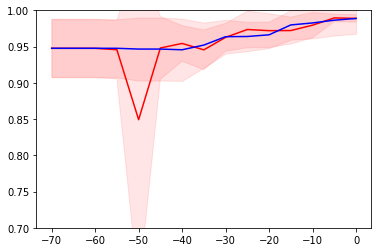

In [92]:
# Dynamic whole ship cable quantities
# Predictors:
# GT, past weeks time series
# Algorithms:
# linear regression

def logifunc(x,x0,k,l):
    return l / (1 + np.exp(-k*(x - x0)))

# Get the data
cursor.execute("SELECT r.project_id, gross_tonnage, prototype, sum(amount) FROM routed as r"
    " LEFT JOIN projects as p ON p.project_id=r.project_id"
    #" LEFT JOIN (SELECT project_id, sum(squares) as ship_squares FROM areas GROUP BY project_id) as a ON r.project_id=a.project_id"
    #" WHERE r.project_id<>1392"
    " GROUP BY r.project_id, gross_tonnage, prototype")
data = np.array(cursor.fetchall()).astype('float32')
print(data.shape)
ships = data[:, 0]
gt = data[:, 1]
pt = data[:, 2]
#sq = data[:, 3]
#gts = data[:, [1, 3]]
y = data[:, -1]

# init lpo split
p = 2 #ships
lpo = LeavePOut(p)

# update temporary cable counts
cursor.execute("UPDATE progress SET cables=0")
cursor.execute(
    "UPDATE progress SET progress.cables=t1.cables FROM"
    " (SELECT project_id, pw, sum(amount) as cables FROM ship_readiness GROUP BY project_id, pw) t1"
    " WHERE t1.project_id=progress.project_id AND t1.pw=progress.wk"
)
cursor.commit()

linearModel = linear_model.LinearRegression()
train_model = linear_model.LinearRegression()
all_linear_acc = []
all_gaussian_acc = []
all_dummy_acc = []
r = 0
for train_i, test_i in lpo.split(y):
    r += 1
    if not (r % 5) == 0:
        continue
    # train regression model
    linearModel.fit( gt[train_i].reshape(-1, 1), y[train_i])
    # collect time series train data
    start = -70
    step = 5
    y_fit = []
    X_fit = []
    X_scalers = []
    X_train = []
    y_train = []
    trace = 16
    sequences = []
    scalers = []
    linear_preds = []
    ys = []
    cumsums = []
    wks = []
    for wk in range(start, 1, step):
        for i in train_i:
            ship = ships[i]
            linear_preds.append(linearModel.predict(gt[[i]].reshape(1, -1))[0])
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            sequences.append(sequence)
            scalers.append(gt[i])
            ys.append(y[i])
            
    best_err = np.inf
    best_dum_err = np.inf
    for lim1 in np.linspace(0.7, 0.99, 11):
        #for lim2 in np.linspace(0.08, 0.2, 5):
        for trace in np.arange(4, 14):
            y_fit = []
            X_fit = []
            for i, sequence in enumerate(sequences):
                linear_pred = linear_preds[i]
                yy = ys[i]
                if sequence.sum()>lim1*linear_pred:
                    s = sequence[-trace:].sum()
                    #if s < lim2*linear_pred:
                    X_fit.append((s, scalers[i]))
                    y_fit.append(yy - sequence.sum())
            if len(X_fit) == 0: break
            X_fit = np.array(X_fit)
            train_model.fit(X_fit, y_fit)
            errs = []
            dum_errs = []
            for i, sequence in enumerate(sequences):
                linear_pred = linear_preds[i]
                if sequence.sum() > lim1*linear_pred:
                    pred = sequence.sum()
                else:
                    pred = linear_pred
                dum_errs.append(np.square(ys[i]-pred))
                if sequence.sum() > 0.8*linear_pred:
                    s = sequence[-trace:].sum()
                    add = train_model.predict(np.array([s, scalers[i]]).reshape(1, 2))[0]
                    pred = sequence.sum() + add
                else:
                    pred = linear_pred
                errs.append(np.square(ys[i]-pred))
            dum_errs = np.array(dum_errs)
            errs = np.array(errs)
            if errs.mean() < best_err:
                best_err = errs.mean()
                params = (lim1, lim2, trace)
                model = deepcopy(train_model)
            if dum_errs.mean() < best_dum_err:
                best_dum_err = dum_errs.mean()
                dum_lim = lim1
    #print(params, dum_lim)
    (lim1, lim2, trace) = params
    #plt.plot(X_fit, np.poly1d(fit(X_fit))
    #plt.show()
    

    # evaluate model
    gaussian_accs = []
    linear_accs = []
    dummy_accs = []
    x = []
    step = step
    for wk in range(start, 1, step):
        gaussian_preds = []
        y_reals = []
        linear_preds = []
        dummy_preds = []
        for i in test_i:
            ship = ships[i]
            linear_pred = linearModel.predict(gt[[i]].reshape(1, -1))[0]
            cursor.execute(
                "SELECT wk, cables FROM progress WHERE"
                " wk <= {} AND project_id={} ORDER BY wk"
                .format(wk, ship)
            )
            data = np.array(cursor.fetchall())
            sequence = data[:, -1]
            xseq = data[:, 0]
            dummy_preds.append(sequence.sum())
            if sequence.sum()>dum_lim*linear_pred:
                linear_preds.append(sequence.sum())
            else:
                linear_preds.append(linear_pred)
            if sequence.sum()>0.8*linear_pred:
                s = sequence[-trace:].sum()
                add = model.predict(np.array([s, gt[i]]).reshape(1, 2))[0]
                pred = sequence.sum() + add
                gaussian_preds.append(pred)
            else:
                gaussian_preds.append(linear_pred)
            y_reals.append(y[i])
        if len(y_reals)<1: continue
        gaussian_mape = mape(y_reals, gaussian_preds)
        linear_mape = mape(y_reals, linear_preds)
        dummy_mape = mape(y_reals, dummy_preds)

        gaussian_accs.append(1-gaussian_mape)
        linear_accs.append(1-linear_mape)
        dummy_accs.append(1-dummy_mape)
        x.append(wk)

    all_dummy_acc.append(dummy_accs)
    all_gaussian_acc.append(gaussian_accs)
    all_linear_acc.append(linear_accs)


all_dummy_acc = np.array(all_dummy_acc)
all_gaussian_acc = np.array(all_gaussian_acc)
all_linear_acc = np.array(all_linear_acc)
print(all_gaussian_acc.mean(), all_linear_acc.mean())
lws = plt.gcf().get_figheight() * plt.gcf().dpi / 0.3
plt.plot(x, all_gaussian_acc.mean(axis=0), 'r')
#plt.plot(x, all_gaussian_acc.min(axis=0), 'r--')
plt.fill_between(x, all_gaussian_acc.mean(axis=0) - all_gaussian_acc.std(axis=0),
                all_gaussian_acc.mean(axis=0) + all_gaussian_acc.std(axis=0),
                alpha=0.1, color='r')
plt.ylim(0.7, 1.0)
#plt.figure()
plt.plot(x, all_linear_acc.mean(axis=0), 'b')
#plt.plot(x, all_linear_acc.min(axis=0), 'b--')
plt.fill_between(x, all_linear_acc.mean(axis=0) - all_linear_acc.std(axis=0),
                all_linear_acc.mean(axis=0) + all_linear_acc.std(axis=0),
                alpha=0.1, color='r')
plt.ylim(0.7, 1.0)
#plt.plot(x, all_dummy_acc.mean(axis=0), 'g')
#plt.plot(x, all_dummy_acc.min(axis=0), 'g--')



plt.show()

# 0.9472411538301978 0.945095115941302 0.8, 0.15, 9